# NeRF 數據流演示 📊

本筆記本詳細演示了 NeRF 從原始輸入數據到最終渲染的完整數據流程。

## 📋 內容概覽
1. 加載真實合成數據集
2. 數據加載和預處理
3. 射線生成過程
4. 3D 點採樣
5. 位置編碼
6. 批次數據準備
7. 數據流可視化

In [2]:
# 導入必要的庫
import sys
import os
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from pathlib import Path
from PIL import Image



# 導入我們的模組
from src.utils.data_utils import NeRFDataLoader
from src.models.encoding import PositionalEncoder

# 設置隨機種子
torch.manual_seed(42)
np.random.seed(42)

print("🚀 NeRF 數據流演示開始！")

🚀 NeRF 數據流演示開始！


## 1. 加載真實合成數據集 🎨

我們將使用真實的合成數據集，包含100張圖像和相應的相機參數。

In [5]:
# 設置數據集路徑
dataset_path = "../data/synthetic"

print(f"📊 加載真實數據集:")
print(f"   - 數據集路徑: {dataset_path}")

# 檢查數據集是否存在
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"數據集路徑不存在: {dataset_path}")

# 加載訓練集變換矩陣
with open(os.path.join(dataset_path, "transforms_train.json"), 'r') as f:
    train_transforms = json.load(f)

# 加載驗證集變換矩陣
with open(os.path.join(dataset_path, "transforms_val.json"), 'r') as f:
    val_transforms = json.load(f)

# 加載測試集變換矩陣
with open(os.path.join(dataset_path, "transforms_test.json"), 'r') as f:
    test_transforms = json.load(f)

print(f"\n✅ 數據集加載完成！")
print(f"   - 訓練集: {len(train_transforms['frames'])} 張圖像")
print(f"   - 驗證集: {len(val_transforms['frames'])} 張圖像")
print(f"   - 測試集: {len(test_transforms['frames'])} 張圖像")
print(f"   - 相機角度 X: {train_transforms['camera_angle_x']:.4f} 弧度")

📊 加載真實數據集:
   - 數據集路徑: ../data/synthetic

✅ 數據集加載完成！
   - 訓練集: 100 張圖像
   - 驗證集: 100 張圖像
   - 測試集: 200 張圖像
   - 相機角度 X: 0.6911 弧度


### 可視化原始數據

/tmp/ipykernel_105177/1247286810.py:43: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_105177/1247286810.py:43: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_105177/1247286810.py:43: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_105177/1247286810.py:43: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


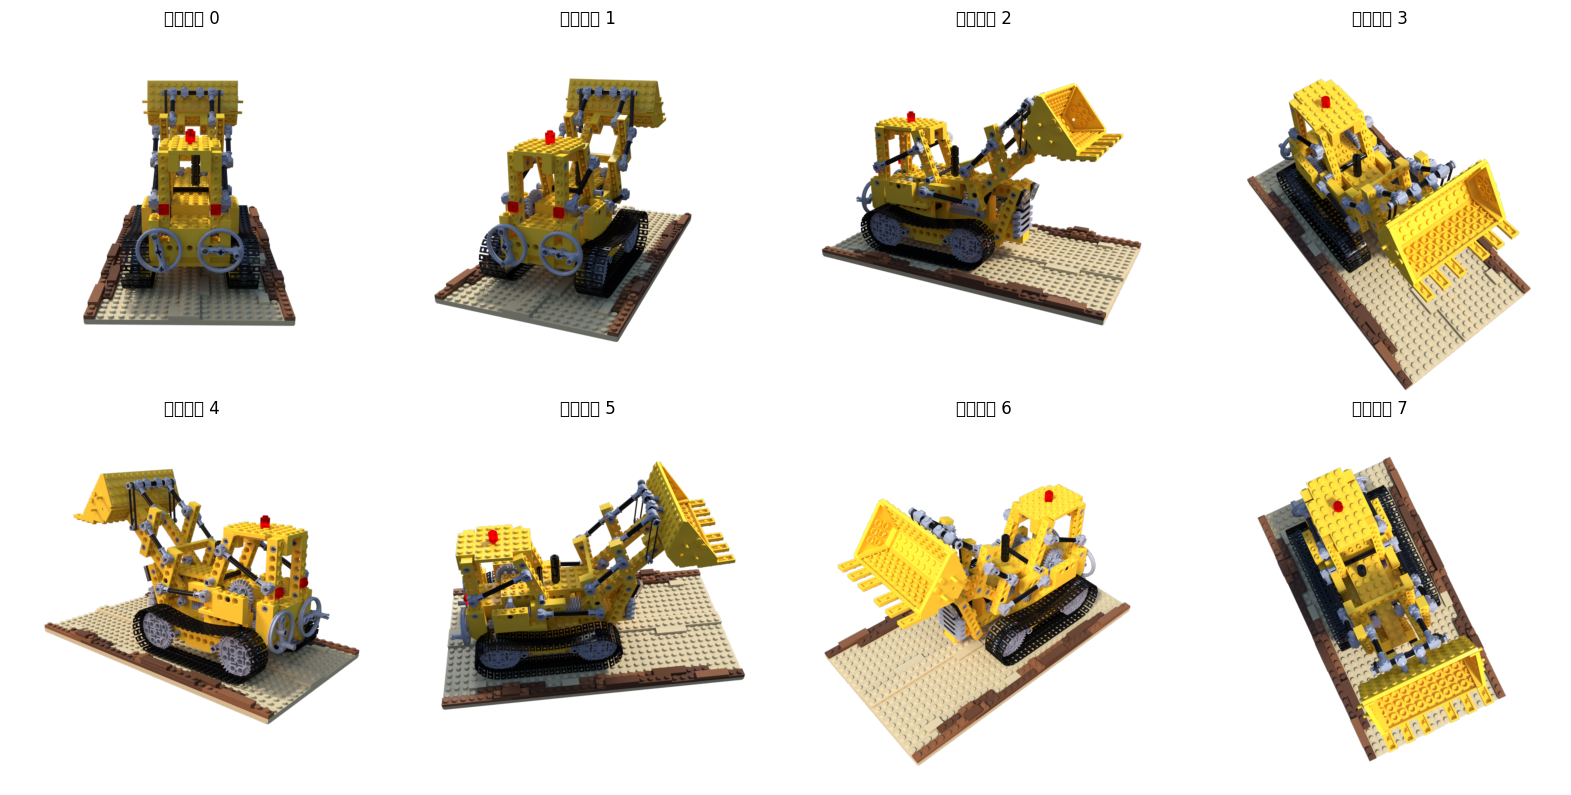


📷 相機參數信息:
   - 相機角度 X: 0.6911 弧度
   - 相機角度 X: 39.60 度

🔢 第一個變換矩陣:
[[-9.99902189e-01  4.19224519e-03 -1.33457193e-02 -5.37983216e-02]
 [-1.39886811e-02 -2.99659073e-01  9.53943670e-01  3.84547043e+00]
 [-4.65661287e-10  9.54037189e-01  2.99688309e-01  1.20808232e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [6]:
# 可視化一些訓練圖像
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# 選擇前8張圖像進行可視化
for i in range(min(8, len(train_transforms['frames']))):
    frame = train_transforms['frames'][i]
    
    # 構建圖像路徑
    # 注意：transforms.json中的路徑可能需要調整
    img_path = frame['file_path']
    if img_path.startswith('./'):
        img_path = img_path[2:]  # 移除 './'
    
    # 嘗試不同的圖像路徑格式
    possible_paths = [
        os.path.join(dataset_path, 'train', f'r_{i}.png'),
        os.path.join(dataset_path, 'train', f'{img_path}.png'),
        os.path.join(dataset_path, img_path + '.png'),
        os.path.join(dataset_path, img_path)
    ]
    
    img_loaded = False
    for path in possible_paths:
        if os.path.exists(path):
            try:
                img = Image.open(path)
                axes[i].imshow(img)
                axes[i].set_title(f'訓練圖像 {i}')
                axes[i].axis('off')
                img_loaded = True
                break
            except Exception as e:
                continue
    
    if not img_loaded:
        # 如果無法加載圖像，顯示佔位符
        axes[i].text(0.5, 0.5, f'圖像 {i}\n無法加載', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'訓練圖像 {i}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# 顯示相機參數信息
print("\n📷 相機參數信息:")
print(f"   - 相機角度 X: {train_transforms['camera_angle_x']:.4f} 弧度")
print(f"   - 相機角度 X: {np.degrees(train_transforms['camera_angle_x']):.2f} 度")

# 顯示第一個變換矩陣
print("\n🔢 第一個變換矩陣:")
transform_matrix = np.array(train_transforms['frames'][0]['transform_matrix'])
print(transform_matrix)

## 2. 數據加載器設置 🔧

創建 NeRF 數據加載器來處理真實數據集。

In [7]:
# 創建數據加載器配置
config = {
    'dataset_path': dataset_path,
    'image_size': (400, 400),  # 根據實際圖像大小調整
    'batch_size': 4,
    'num_rays': 1024,  # 每批次的射線數量
    'near': 2.0,       # 近平面
    'far': 6.0,        # 遠平面
    'white_background': True
}

print("⚙️ 數據加載器配置:")
for key, value in config.items():
    print(f"   - {key}: {value}")

# 創建數據加載器
try:
    # 嘗試使用我們的數據加載器
    data_loader = NeRFDataLoader(
        dataset_path=dataset_path,
        split='train',
        image_size=config['image_size'],
        batch_size=config['batch_size']
    )
    print("\n✅ 數據加載器創建成功！")
except Exception as e:
    print(f"\n❌ 數據加載器創建失敗: {e}")
    print("使用簡化的數據處理方式...")
    
    # 簡化的數據處理
    class SimpleDataLoader:
        def __init__(self, transforms, dataset_path):
            self.transforms = transforms
            self.dataset_path = dataset_path
            self.frames = transforms['frames']
            self.camera_angle_x = transforms['camera_angle_x']
        
        def get_sample(self, idx=0):
            frame = self.frames[idx]
            transform_matrix = np.array(frame['transform_matrix'])
            return {
                'transform_matrix': transform_matrix,
                'camera_angle_x': self.camera_angle_x,
                'file_path': frame['file_path']
            }
    
    data_loader = SimpleDataLoader(train_transforms, dataset_path)
    print("✅ 簡化數據加載器創建成功！")

⚙️ 數據加載器配置:
   - dataset_path: ../data/synthetic
   - image_size: (400, 400)
   - batch_size: 4
   - num_rays: 1024
   - near: 2.0
   - far: 6.0
   - white_background: True

❌ 數據加載器創建失敗: NeRFDataLoader.__init__() got an unexpected keyword argument 'dataset_path'
使用簡化的數據處理方式...
✅ 簡化數據加載器創建成功！


## 3. 射線生成過程 📡

演示如何從相機參數生成射線。

In [8]:
def generate_rays(H, W, focal, c2w):
    """
    生成射線
    
    Args:
        H: 圖像高度
        W: 圖像寬度  
        focal: 焦距
        c2w: 相機到世界坐標變換矩陣 (4x4)
    
    Returns:
        rays_o: 射線起點 (H*W, 3)
        rays_d: 射線方向 (H*W, 3)
    """
    # 創建像素坐標網格
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), 
                       np.arange(H, dtype=np.float32), 
                       indexing='xy')
    
    # 轉換到相機坐標系
    dirs = np.stack([(i - W * 0.5) / focal, 
                     -(j - H * 0.5) / focal, 
                     -np.ones_like(i)], -1)
    
    # 轉換到世界坐標系
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    
    return rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)

# 獲取一個樣本
sample = data_loader.get_sample(0)
transform_matrix = sample['transform_matrix']
camera_angle_x = sample['camera_angle_x']

# 設置圖像參數
H, W = 100, 100  # 使用較小的尺寸進行演示
focal = 0.5 * W / np.tan(0.5 * camera_angle_x)

print(f"📐 射線生成參數:")
print(f"   - 圖像尺寸: {H} x {W}")
print(f"   - 焦距: {focal:.2f}")
print(f"   - 相機角度: {np.degrees(camera_angle_x):.2f}°")

# 生成射線
rays_o, rays_d = generate_rays(H, W, focal, transform_matrix)

print(f"\n🎯 射線信息:")
print(f"   - 射線起點形狀: {rays_o.shape}")
print(f"   - 射線方向形狀: {rays_d.shape}")
print(f"   - 總射線數量: {len(rays_o)}")

# 顯示一些射線的起點和方向
print(f"\n📊 前5條射線:")
for i in range(5):
    print(f"   射線 {i}: 起點 {rays_o[i]}, 方向 {rays_d[i]}")

📐 射線生成參數:
   - 圖像尺寸: 100 x 100
   - 焦距: 138.89
   - 相機角度: 39.60°

🎯 射線信息:
   - 射線起點形狀: (10000, 3)
   - 射線方向形狀: (10000, 3)
   - 總射線數量: 10000

📊 前5條射線:
   射線 0: 起點 [-0.05379832  3.84547043  1.20808232], 方向 [ 0.37481973 -1.05678502  0.04376509]
   射線 1: 起點 [-0.05379832  3.84547043  1.20808232], 方向 [ 0.36762043 -1.05688573  0.04376509]
   射線 2: 起點 [-0.05379832  3.84547043  1.20808232], 方向 [ 0.36042113 -1.05698645  0.04376509]
   射線 3: 起點 [-0.05379832  3.84547043  1.20808232], 方向 [ 0.35322183 -1.05708717  0.04376509]
   射線 4: 起點 [-0.05379832  3.84547043  1.20808232], 方向 [ 0.34602254 -1.05718789  0.04376509]


## 4. 3D 點採樣 🎲

沿射線採樣 3D 點。

In [10]:
def sample_points_along_rays(rays_o, rays_d, near, far, n_samples):
    """
    沿射線採樣點
    
    Args:
        rays_o: 射線起點 (N, 3)
        rays_d: 射線方向 (N, 3)
        near: 近平面距離
        far: 遠平面距離
        n_samples: 每條射線的採樣點數
    
    Returns:
        points: 採樣點 (N, n_samples, 3)
        z_vals: 深度值 (N, n_samples)
    """
    # 在近遠平面之間均勻採樣
    t_vals = np.linspace(0., 1., n_samples)
    z_vals = near * (1. - t_vals) + far * t_vals
    
    # 添加隨機擾動
    mids = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
    upper = np.concatenate([mids, z_vals[..., -1:]], -1)
    lower = np.concatenate([z_vals[..., :1], mids], -1)
    t_rand = np.random.rand(*z_vals.shape)
    z_vals = lower + (upper - lower) * t_rand
    
    # 計算 3D 點
    points = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    
    return points, z_vals

# 採樣參數
near = 2.0
far = 6.0
n_samples = 64

print(f"🎲 3D 點採樣參數:")
print(f"   - 近平面: {near}")
print(f"   - 遠平面: {far}")
print(f"   - 每條射線採樣點數: {n_samples}")

# 選擇前1000條射線進行演示
n_rays_demo = 1000
demo_rays_o = rays_o[:n_rays_demo]
demo_rays_d = rays_d[:n_rays_demo]

# 沿射線採樣點
points, z_vals = sample_points_along_rays(demo_rays_o, demo_rays_d, near, far, n_samples)

print(f"\n📍 採樣結果:")
print(f"   - 3D 點形狀: {points.shape}")
print(f"   - 深度值形狀: {z_vals.shape}")
print(f"   - 總採樣點數: {points.shape[0] * points.shape[1]}")

# 顯示一些採樣點
print(f"\n🔍 第一條射線的前5個採樣點:")
for i in range(5):
    print(f"   點 {i}: {points[0, i]}, 深度: {z_vals[i]:.3f}")

🎲 3D 點採樣參數:
   - 近平面: 2.0
   - 遠平面: 6.0
   - 每條射線採樣點數: 64

📍 採樣結果:
   - 3D 點形狀: (1000, 64, 3)
   - 深度值形狀: (64,)
   - 總採樣點數: 64000

🔍 第一條射線的前5個採樣點:
   點 0: [0.69918399 1.7224754  1.29600282], 深度: 2.009
   點 1: [0.7206553  1.66193814 1.29850988], 深度: 2.066
   點 2: [0.73489198 1.62179855 1.3001722 ], 深度: 2.104
   點 3: [0.77442708 1.51033136 1.30478844], 深度: 2.210
   點 4: [0.78090857 1.49205712 1.30554524], 深度: 2.227


## 5. 位置編碼 🔢

對 3D 點和射線方向進行位置編碼。

In [19]:
# 創建位置編碼器
pos_encoder = PositionalEncoder(config={
    'input_dims': 3,  # 修正：應該是input_dims，不是output_dims
    'num_freqs': 10,
    'include_input': True
})

dir_encoder = PositionalEncoder(config={
    'input_dims': 3,  # 修正：應該是input_dims，不是output_dims
    'num_freqs': 4,
    'include_input': True
})

print(f"🔢 位置編碼器配置:")
print(f"   - 位置編碼輸出維度: {pos_encoder.output_dims}")
print(f"   - 方向編碼輸出維度: {dir_encoder.output_dims}")

# 對採樣點進行位置編碼
# 重塑為 (N*n_samples, 3) 以便編碼
points_flat = points.reshape(-1, 3)
encoded_points = pos_encoder(torch.from_numpy(points_flat).float())  # 修正：使用forward()方法，即直接調用

# 對射線方向進行編碼
encoded_dirs = dir_encoder(torch.from_numpy(demo_rays_d).float())  # 修正：使用forward()方法，即直接調用

print(f"\n📊 編碼結果:")
print(f"   - 編碼後點的形狀: {encoded_points.shape}")
print(f"   - 編碼後方向的形狀: {encoded_dirs.shape}")

# 顯示編碼前後的對比
print(f"\n🔍 編碼前後對比 (第一個點):")
print(f"   - 原始點: {points_flat[0]}")
print(f"   - 編碼後維度: {encoded_points[0].shape}")
print(f"   - 編碼後前10個值: {encoded_points[0][:10].numpy()}")

🔢 位置編碼器配置:
   - 位置編碼輸出維度: 63
   - 方向編碼輸出維度: 27

📊 編碼結果:
   - 編碼後點的形狀: torch.Size([64000, 63])
   - 編碼後方向的形狀: torch.Size([1000, 27])

🔍 編碼前後對比 (第一個點):
   - 原始點: [0.69918399 1.7224754  1.29600282]
   - 編碼後維度: torch.Size([63])
   - 編碼後前10個值: [ 0.699184    1.7224754   1.2960029   0.6435934   0.9885188   0.96248126
  0.7653676  -0.15109815  0.27134815  0.985171  ]


## 6. 批次數據準備 📦

準備用於神經網絡訓練的批次數據。

In [20]:
def prepare_batch_data(points, dirs, batch_size=1024):
    """
    準備批次數據
    
    Args:
        points: 編碼後的點 (N, D_pos)
        dirs: 編碼後的方向 (M, D_dir)
        batch_size: 批次大小
    
    Returns:
        batches: 批次數據列表
    """
    n_points = points.shape[0]
    n_dirs = dirs.shape[0]
    
    # 確保點和方向數量匹配（每條射線有多個點）
    points_per_ray = n_points // n_dirs
    
    batches = []
    for i in range(0, n_points, batch_size):
        end_idx = min(i + batch_size, n_points)
        batch_points = points[i:end_idx]
        
        # 為每個點分配對應的方向
        ray_indices = torch.arange(i, end_idx) // points_per_ray
        ray_indices = torch.clamp(ray_indices, 0, n_dirs - 1)
        batch_dirs = dirs[ray_indices]
        
        batches.append({
            'points': batch_points,
            'dirs': batch_dirs,
            'batch_size': batch_points.shape[0]
        })
    
    return batches

# 準備批次數據
batch_size = 1024
batches = prepare_batch_data(encoded_points, encoded_dirs, batch_size)

print(f"📦 批次數據準備:")
print(f"   - 批次大小: {batch_size}")
print(f"   - 總批次數: {len(batches)}")
print(f"   - 總數據點數: {sum(batch['batch_size'] for batch in batches)}")

# 顯示第一個批次的信息
first_batch = batches[0]
print(f"\n🔍 第一個批次信息:")
print(f"   - 點的形狀: {first_batch['points'].shape}")
print(f"   - 方向的形狀: {first_batch['dirs'].shape}")
print(f"   - 批次大小: {first_batch['batch_size']}")

📦 批次數據準備:
   - 批次大小: 1024
   - 總批次數: 63
   - 總數據點數: 64000

🔍 第一個批次信息:
   - 點的形狀: torch.Size([1024, 63])
   - 方向的形狀: torch.Size([1024, 27])
   - 批次大小: 1024


## 7. 數據流可視化 📈

可視化整個數據流程。

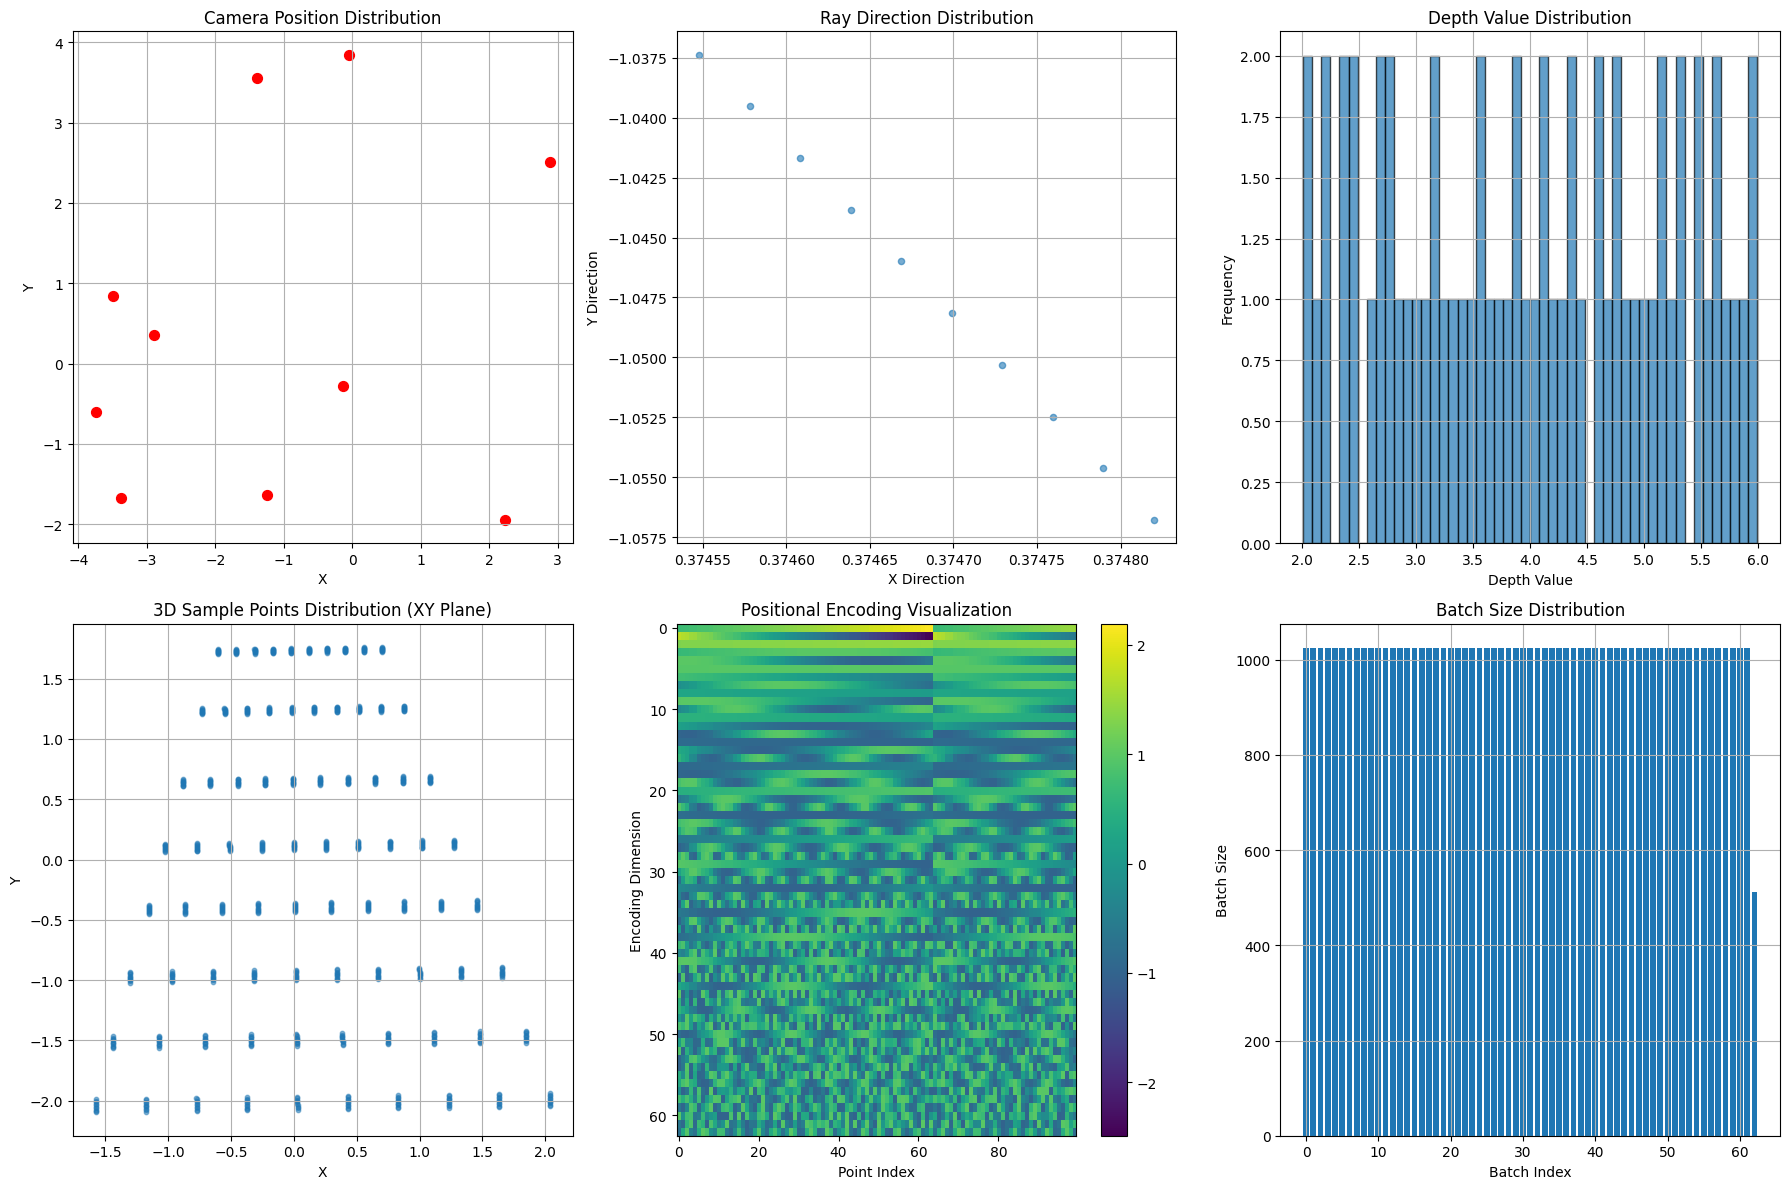


🎯 NeRF 數據流程總結:
1. 📸 輸入圖像: 100 張
2. 📡 生成射線: 10000 條
3. 🎲 3D 採樣點: 64000 個
4. 🔢 位置編碼: 63 維
5. 📦 批次數據: 63 個批次
6. 🧠 準備輸入神經網絡進行訓練


In [22]:
# 創建數據流可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. 相機位置可視化
ax = axes[0, 0]
camera_positions = []
for i in range(min(10, len(train_transforms['frames']))):
    transform = np.array(train_transforms['frames'][i]['transform_matrix'])
    camera_positions.append(transform[:3, 3])

camera_positions = np.array(camera_positions)
ax.scatter(camera_positions[:, 0], camera_positions[:, 1], c='red', s=50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Camera Position Distribution')
ax.grid(True)

# 2. 射線方向分佈
ax = axes[0, 1]
sample_rays = demo_rays_d[::100]  # 每100條射線取一條
ax.scatter(sample_rays[:, 0], sample_rays[:, 1], alpha=0.6, s=20)
ax.set_xlabel('X Direction')
ax.set_ylabel('Y Direction')
ax.set_title('Ray Direction Distribution')
ax.grid(True)

# 3. 深度值分佈
ax = axes[0, 2]
ax.hist(z_vals.flatten(), bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel('Depth Value')
ax.set_ylabel('Frequency')
ax.set_title('Depth Value Distribution')
ax.grid(True)

# 4. 3D 點分佈
ax = axes[1, 0]
sample_points = points[::10, ::8].reshape(-1, 3)  # 採樣部分點
ax.scatter(sample_points[:, 0], sample_points[:, 1], alpha=0.5, s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('3D Sample Points Distribution (XY Plane)')
ax.grid(True)

# 5. 位置編碼可視化
ax = axes[1, 1]
encoded_sample = encoded_points[:100].numpy()  # 前100個編碼點
im = ax.imshow(encoded_sample.T, aspect='auto', cmap='viridis')
ax.set_xlabel('Point Index')
ax.set_ylabel('Encoding Dimension')
ax.set_title('Positional Encoding Visualization')
plt.colorbar(im, ax=ax)

# 6. 批次大小分佈
ax = axes[1, 2]
batch_sizes = [batch['batch_size'] for batch in batches]
ax.bar(range(len(batch_sizes)), batch_sizes)
ax.set_xlabel('Batch Index')
ax.set_ylabel('Batch Size')
ax.set_title('Batch Size Distribution')
ax.grid(True)

plt.tight_layout()
plt.show()

# 數據流程總結
print("\n🎯 NeRF 數據流程總結:")
print("="*50)
print(f"1. 📸 輸入圖像: {len(train_transforms['frames'])} 張")
print(f"2. 📡 生成射線: {len(rays_o)} 條")
print(f"3. 🎲 3D 採樣點: {points.shape[0] * points.shape[1]} 個")
print(f"4. 🔢 位置編碼: {encoded_points.shape[1]} 維")
print(f"5. 📦 批次數據: {len(batches)} 個批次")
print(f"6. 🧠 準備輸入神經網絡進行訓練")
print("="*50)